<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/TestonUNET-sh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')



Mounted at /gdrive


In [2]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TESI/TEST/UnetNEWIMAGES-5e-5-drop0.2.h5", compile=False)

In [3]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
seed=42
from keras.preprocessing.image import ImageDataGenerator


In [10]:

val_img_path = "/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/"
val_mask_path = "/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/"

In [11]:
img_data_gen_args_val = dict(rescale=1./255)

mask_data_gen_args_val = dict(
                     preprocessing_function = lambda x: np.where(x>0.5, 1, 0).astype(x.dtype)
                     
                     ) #Binarize the output again. 

image_data_generator_val = ImageDataGenerator(**img_data_gen_args_val)
mask_data_generator_val = ImageDataGenerator(**mask_data_gen_args_val)

In [12]:
batch_size=16


In [13]:
import os

In [17]:
seed=42


valid_img_generator = image_data_generator_val.flow_from_directory(val_img_path, 
                                                               seed=seed, 
                                                               batch_size=255, 
                                                               color_mode = 'grayscale', 
                                                               shuffle=False,
                                                               
                                                               target_size=(256,256),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator_val.flow_from_directory(val_mask_path, 
                                                               seed=seed, 
                                                               batch_size=255, 
                                                               target_size=(256,256),
                                                               shuffle=False,
                                                               
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


val_generator = zip(valid_img_generator, valid_mask_generator)

Found 255 images belonging to 1 classes.
Found 255 images belonging to 1 classes.


In [18]:
a,b=val_generator.__next__()


In [19]:
for file in valid_img_generator.filenames:
    print(file)

images/0001.png
images/00010.png
images/000100.png
images/000101.png
images/000102.png
images/000103.png
images/000104.png
images/000105.png
images/000106.png
images/000107.png
images/000108.png
images/000109.png
images/00011.png
images/000110.png
images/000111.png
images/000112.png
images/000113.png
images/000114.png
images/000115.png
images/000116.png
images/000117.png
images/000118.png
images/000119.png
images/00012.png
images/000120.png
images/000121.png
images/000122.png
images/000123.png
images/000124.png
images/000125.png
images/000126.png
images/000127.png
images/000128.png
images/000129.png
images/00013.png
images/000130.png
images/000131.png
images/000132.png
images/000133.png
images/000134.png
images/000135.png
images/000136.png
images/000137.png
images/000138.png
images/000139.png
images/00014.png
images/000140.png
images/000141.png
images/000142.png
images/000143.png
images/000144.png
images/000145.png
images/000146.png
images/000147.png
images/000148.png
images/000149.png

In [106]:
val_img_path = "/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images"
val_mask_path = "/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks"

In [107]:

# img_data_gen_args_val = dict(rescale=1./255)

mask_data_gen_args_val = dict(
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                     
                     ) #Binarize the output again. 

image_data_generator_val = ImageDataGenerator(rescale=1./255)
mask_data_generator_val = ImageDataGenerator(**mask_data_gen_args_val)

In [108]:
batch_size=16


In [109]:
def sort_img_names(dir:str):
    names = [os.path.join(dir, x) for x in os.listdir(dir)]
    names = sorted(names, key=lambda x: int(x.split('/')[-1].split('.')[0]))
    return names
val_img_names = pd.DataFrame(sort_img_names(val_img_path), columns=['filename'])
val_mask_names = pd.DataFrame(sort_img_names(val_mask_path), columns=['filename'])
print(val_img_names[:10])

                                            filename
0  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
1  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
2  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
3  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
4  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
5  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
6  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
7  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
8  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...
9  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/...


In [110]:
seed=42


valid_img_generator = image_data_generator_val.flow_from_dataframe(val_img_names, 
                                                               seed=seed, 
                                                               batch_size=255, 
                                                               color_mode = 'grayscale', 
                                                               shuffle=False,
                                                               
                                                               target_size=(256,256),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator_val.flow_from_dataframe(val_mask_names,
                                                               seed=seed, 
                                                               batch_size=255, 
                                                               target_size=(256,256),
                                                               shuffle=False,
                                                               
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


val_generator = zip(valid_img_generator, valid_mask_generator)

Found 255 validated image filenames.
Found 255 validated image filenames.


In [111]:
for file in valid_img_generator.filenames:
    print(file)

/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0001.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0002.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0003.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0004.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0005.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0006.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0007.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0008.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/0009.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/00010.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/00011.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/00012.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_images/images/00013.png
/gdrive/MyDrive/TESI/TEST/TEST-TOT

In [112]:
for file in valid_mask_generator.filenames:
    print(file)

/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0001.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0002.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0003.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0004.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0005.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0006.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0007.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0008.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/0009.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/00010.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/00011.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/00012.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/masks/00013.png
/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-022/test_masks/mas

In [113]:
a,b=val_generator.__next__()

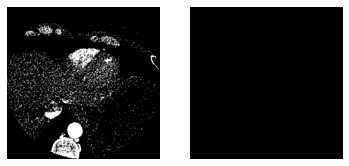

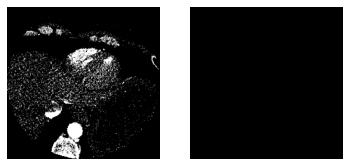

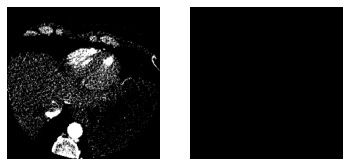

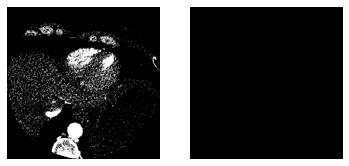

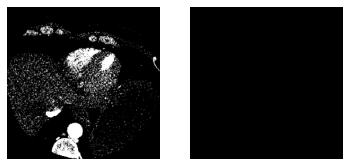

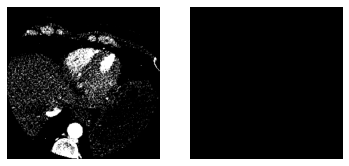

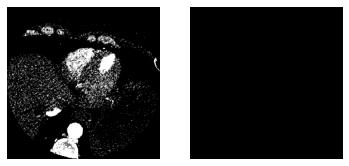

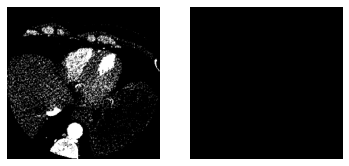

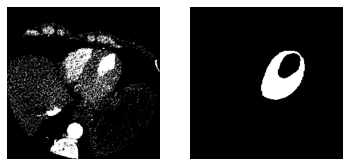

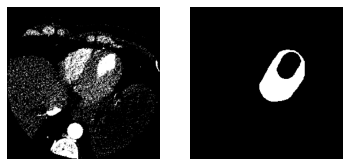

In [115]:
for i in range(40,50):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

In [133]:
from sklearn.metrics import precision_score,recall_score
from tensorflow.keras.metrics import MeanIoU,Recall,Precision,BinaryAccuracy,IoU



1/1 [==============================] - 0s 26ms/step


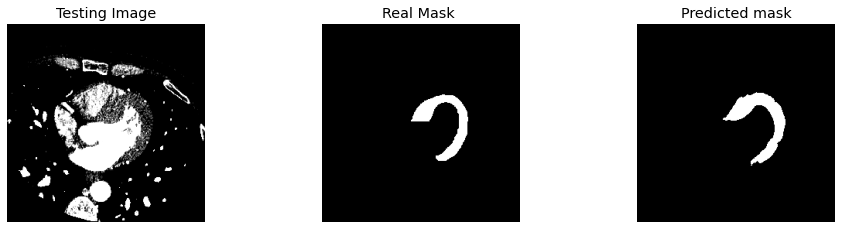

In [130]:

  test_img_number = random.randint(130,131)
  test_img = a[test_img_number]
  ground_truth=b[test_img_number]


  #test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5 ).astype(np.float32)
  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.axis('off')
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')



  plt.subplot(232)
  plt.title('Real Mask ')
  plt.axis('off')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)


  plt.axis('off')

  plt.title('Predicted mask')
  plt.imshow(prediction, cmap='gray')

  plt.show()

In [134]:
#IoU for a single image
n_classes = 2
IOU_keras = IoU(num_classes=n_classes,target_class_ids=(0,1))  

IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("IoU =", IOU_keras.result().numpy())

IoU = 0.84879637


In [135]:
#MeanIoU for a single image
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.84879637


In [136]:
#Precision for a single image
p= tf.keras.metrics.Precision()

p.update_state(ground_truth[:,:,0], prediction)
print("Precision =", p.result().numpy())

Precision = 0.77124465


In [137]:
#Recall for a single image
p= tf.keras.metrics.Recall()
p.update_state(ground_truth[:,:,0], prediction)
print("Recall =", p.result().numpy())

Recall = 0.89805096


In [138]:
#Precision score for a single image
precision=precision_score(ground_truth[:,:,0], prediction, average='micro',zero_division=1)
print(precision)

0.771244635193133


In [139]:
#Recall for a single image

recall=recall_score(ground_truth[:,:,0], prediction,average='weighted',zero_division=1)
print(recall)

0.8980509745127436


In [140]:
import pandas as pd


1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 18ms/s

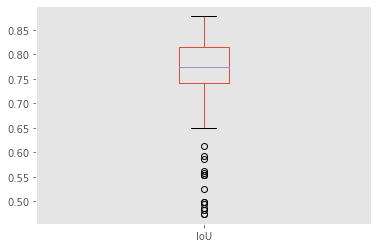

In [141]:
#MeanIoU for all images
from tensorflow.keras.metrics import MeanIoU

IoU_values = []
for img in range(a.shape[0]-1):


    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
    
    IoU = MeanIoU(num_classes=n_classes)

    IoU.update_state(ground_truth[:,:,0], prediction)

    IoU = IoU.result().numpy()
    IoU_values.append(IoU)


    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
boxplot = df.boxplot(grid=False)
std=df.std()
print("Mean IoU is: ", mean_IoU)
print("standard deviation is ",std)

1/1 [==============================] - 0s 17ms/step
0.47466943
1/1 [==============================] - 0s 15ms/step
0.5534778
1/1 [==============================] - 0s 15ms/step
0.5531212
1/1 [==============================] - 0s 16ms/step
0.52515304
1/1 [==============================] - 0s 18ms/step
0.55794406
1/1 [==============================] - 0s 20ms/step
0.5536537
1/1 [==============================] - 0s 19ms/step
0.5621609
1/1 [==============================] - 0s 18ms/step
0.58726645
1/1 [==============================] - 0s 15ms/step
0.59207237
1/1 [==============================] - 0s 16ms/step
0.6508674
1/1 [==============================] - 0s 19ms/step
0.6539241
1/1 [==============================] - 0s 16ms/step
0.61355484
1/1 [==============================] - 0s 21ms/step
0.6910198
1/1 [==============================] - 0s 16ms/step
0.7027768
1/1 [==============================] - 0s 17ms/step
0.70090836
1/1 [==============================] - 0s 16ms/step
0.7591287
1

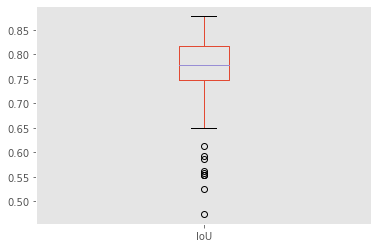

In [142]:
#MeanIoU excluding black masks
from tensorflow.keras.metrics import MeanIoU

IoU_values = []
for img in range(49,133):


    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
    
    IoU = MeanIoU(num_classes=n_classes)

    IoU.update_state(ground_truth[:,:,0], prediction)

    IoU = IoU.result().numpy()
    IoU_values.append(IoU)


    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
boxplot = df.boxplot(grid=False)
std=df.std()
print("Mean IoU is: ", mean_IoU)
print("standard deviation is ",std)

1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 29ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 18ms/s

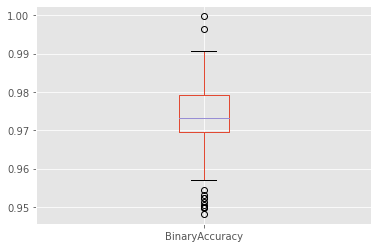

In [ ]:
#Binary Accuracy for all images
import pandas as pd
BinaryAccuracy_values = []
for img in range(a.shape[0]-1):
      temp_img = a[img]
      ground_truth=b[img]
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      Accuracy=BinaryAccuracy()
      Accuracy.update_state(ground_truth[:,:,0], prediction)
      Accuracy = Accuracy.result().numpy()
      BinaryAccuracy_values.append(Accuracy)

      print(Accuracy)
      

df = pd.DataFrame(BinaryAccuracy_values, columns=["BinaryAccuracy"])
df = df[df.BinaryAccuracy != 1.0]    
mean_acc = df.mean().values
boxplot = df.boxplot()

print("Mean acc is: ", mean_acc)

In [ ]:
#Precision for all images
Precision_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    precision=precision_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
    Precision_values.append (precision)
    print(precision)


df = pd.DataFrame(Precision_values, columns=["Precision"])
df = df[df.Precision != 1.0]    
mean_precision = df.mean().values
print("Mean Precision is: ", mean_precision)

1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 16ms/s

In [ ]:
#Recall for all images
Recall_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    recall=recall_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
    Recall_values.append (recall)
    print(recall)


df = pd.DataFrame(Recall_values, columns=["Recall"])
df = df[df.Recall != 1.0]    
mean_rec = df.mean().values
print("Mean Recall is: ", mean_rec)

1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 15ms/s

1/1 [==============================] - 0s 18ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 15ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 16ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 18ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 18ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 18ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 20ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 19ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 16ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 20ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
1/1 [==============================] - 0s 18ms/step
tf.Tensor(1.0, shape=(), dty

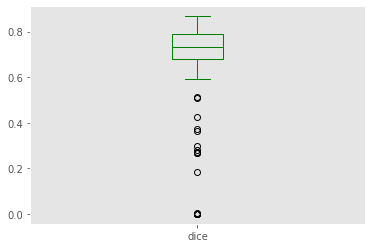

In [ ]:
import pandas as pd

dice_values = []
for img in range(a.shape[0]-1):


    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
    dice = dice_coefficient(ground_truth[:,:,0], prediction)
    dice_values.append(dice)
    print(dice)
    
df = pd.DataFrame(dice_values, columns=["dice"])
df = df[df.dice != 1.0]    
mean_dice = df.mean().values
boxplot_dice = df.boxplot(patch_artist=False,color='g',grid=False)

std=df.std()
print("Dice coefficient is: ", mean_dice)
print("standard deviation is ",std)



1/1 [==============================] - 0s 20ms/step
0.95184326
1/1 [==============================] - 0s 16ms/step
0.9549408
1/1 [==============================] - 0s 18ms/step
0.95196533
1/1 [==============================] - 0s 16ms/step
0.95181274
1/1 [==============================] - 0s 17ms/step
0.95259094
1/1 [==============================] - 0s 17ms/step
0.95344543
1/1 [==============================] - 0s 17ms/step
0.95448303
1/1 [==============================] - 0s 17ms/step
0.95236206
1/1 [==============================] - 0s 16ms/step
0.9521942
1/1 [==============================] - 0s 17ms/step
0.9530792
1/1 [==============================] - 0s 17ms/step
0.9517822
1/1 [==============================] - 0s 18ms/step
0.9667511
1/1 [==============================] - 0s 17ms/step
0.97265625
1/1 [==============================] - 0s 18ms/step
0.97358704
1/1 [==============================] - 0s 19ms/step
0.9793701
1/1 [==============================] - 0s 16ms/step
0.9836883

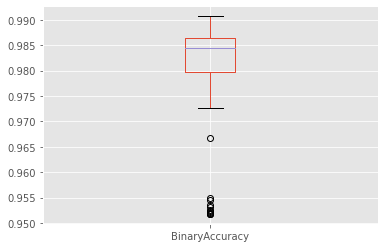

In [ ]:
#Binary Accuracy excluding black masks
import pandas as pd
BinaryAccuracy_values = []
for img in range(58,121):
      temp_img = a[img]
      ground_truth=b[img]
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      Accuracy=BinaryAccuracy()
      Accuracy.update_state(ground_truth[:,:,0], prediction)
      Accuracy = Accuracy.result().numpy()
      BinaryAccuracy_values.append(Accuracy)

      print(Accuracy)
      


df = pd.DataFrame(BinaryAccuracy_values, columns=["BinaryAccuracy"])
df = df[df.BinaryAccuracy != 1.0]    
mean_acc = df.mean().values
boxplot = df.boxplot()

print("Mean acc is: ", mean_acc)

In [ ]:
#Precision excluding black masks
Precision_values = []
for img in range(58,121):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    precision=precision_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
    Precision_values.append (precision)
    print(precision)


df = pd.DataFrame(Precision_values, columns=["Precision"])
df = df[df.Precision != 1.0]    
mean_precision = df.mean().values
print("Mean Precision is: ", mean_precision)

1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 20ms/step
0.9741321325634649
1/1 [==============================] - 0s 21ms/step
0.9583318298344373
1/1 [==============================] - 0s 17ms/step
0.9267327882493286
1/1 [==============================] - 0s 19ms/step
0.9588836243881369
1/1 [==============================] - 0s 17ms/step
0.9271991776005334
1/1 [========================

In [ ]:
#Recall excluding black masks
Recall_values = []
for img in range(58,121):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    recall=recall_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
    Recall_values.append (recall)
    print(recall)


df = pd.DataFrame(Recall_values, columns=["Recall"])
df = df[df.Recall != 1.0]    
mean_rec = df.mean().values
print("Mean Recall is: ", mean_rec)

1/1 [==============================] - 0s 20ms/step
0.6796875
1/1 [==============================] - 0s 18ms/step
0.6875
1/1 [==============================] - 0s 18ms/step
0.68359375
1/1 [==============================] - 0s 19ms/step
0.68359375
1/1 [==============================] - 0s 16ms/step
0.68359375
1/1 [==============================] - 0s 17ms/step
0.67578125
1/1 [==============================] - 0s 16ms/step
0.67578125
1/1 [==============================] - 0s 17ms/step
0.6796875
1/1 [==============================] - 0s 16ms/step
0.66796875
1/1 [==============================] - 0s 16ms/step
0.66796875
1/1 [==============================] - 0s 17ms/step
0.6640625
1/1 [==============================] - 0s 24ms/step
0.7179525221458479
1/1 [==============================] - 0s 20ms/step
0.7686147951941671
1/1 [==============================] - 0s 20ms/step
0.8062863230990273
1/1 [==============================] - 0s 16ms/step
0.8641687610285527
1/1 [=========================

1/1 [==============================] - 0s 20ms/step
tf.Tensor(3.1685676e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 19ms/step
tf.Tensor(3.3863866e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 21ms/step
tf.Tensor(3.17662e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 16ms/step
tf.Tensor(3.166561e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 18ms/step
tf.Tensor(3.2185387e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 16ms/step
tf.Tensor(3.277614e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 21ms/step
tf.Tensor(3.3523296e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 20ms/step
tf.Tensor(3.2030748e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 19ms/step
tf.Tensor(3.1918287e-08, shape=(), dtype=float32)
1/1 [==============================] - 0s 22ms/step
tf.Tensor(3.2520326e-08, shape=(),

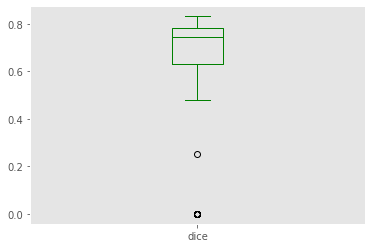

In [ ]:
#Dice excluding black masks
dice_values = []
for img in range(58,121):


    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
    dice = dice_coefficient(ground_truth[:,:,0], prediction)
    dice_values.append(dice)
    print(dice)
    
df = pd.DataFrame(dice_values, columns=["dice"])
df = df[df.dice != 1.0]    
mean_dice = df.mean().values
boxplot_dice = df.boxplot(patch_artist=False,color='g',grid=False)

std=df.std()
print("Dice coefficient is: ", mean_dice)
print("standard deviation is ",std)

